---

# Программная работа по оптимизации 2
*Выполнена Боревским Андреем, студентом 193 группы*

---------

### **Пункт 4**. Проверка реализации `hes_vec`


#### 4.1 Подключение необходимых внешних библиотек

In [1]:
from libsvm.svmutil import *
from sklearn.datasets import load_svmlight_file

from scipy.sparse import diags
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

#### 4.2 Подключение необходимых внутренних библиотек

In [2]:
from utils import LineSearchTool, get_line_search_tool
from oracles import BaseSmoothOracle, QuadraticOracle, create_log_reg_oracle, hess_vec_finite_diff
from optimization import conjugate_gradients, hessian_free_newton, lbfgs, gradient_descent, newton

#### 4.3 Цикл проверки

In [4]:
A =  np.random.randn(10, 10)  # Случайнай матрица А
b =  np.random.randn(10)      # Случайная матрица b

test_oracle = create_log_reg_oracle(A, b, 1)  # ЛогРег оракул
delta_hess = []
pbar = tqdm(range(20))
for i in pbar: # Проверка на 20 случайных точках
    pbar.set_description("Processing {0}th point".format(i + 1))
    test_x =  np.random.randn(10)  # Случайная точка x
    v = np.random.randn(10)  # Случайный вектор v
    true_hess = hess_vec_finite_diff(test_oracle.func, test_x, v)  # Результат разностной аппроксимации
    trial = test_oracle.hess_vec(test_x, v) # Результат собственно реализованного метода
    delta_hess.append(np.mean(np.abs(trial - true_hess)))  
print('Average delta for approximation & self-implemented vector hessian equals', f'{np.mean(delta_hess):.6f}')

  0%|          | 0/20 [00:00<?, ?it/s]

Average delta for approximation & self-implemented vector hessian equals 0.000009


----
## Эксперименты

### Эксперимент 1. Зависимость числа итераций метода сопряженных градиентов от числа обусловленности и размерности пространства

----

Дизайн Эксперимента

> Эксперимент, как и заявлено в описании, повторяет аналогичный из первой практики. Процитируем: "Используется аналогичные квадратичные функции порядка n. Присутсвуют 5 семейств функции, диверсифицирующихся по значениям n: от 10 до $10^5$. Таким образом, становится возможным понять зависимость числа итераций и от размерности n (через сравнение семейств функций), и самого $\mathcal{k}$. Напомним, что последнее является значением обусловленности, вычисляющегося по формуле:

> $$\mathcal{k} = \frac{\|\nabla f(x)\|}{\|f(x)\|}\|x\|$$

> Итерируясь по семействам кривых, мы восемь раз проводим эксперимент: создаем диагональную разреженную матрицу размера $n \times n$, где элементы диагонали лежат в интервале от 1 до $\mathcal{k}$, обязательно включая границы. Далее случайным образом задаются векторы $x$ и $b$, после чего осуществляется градиентный спуск. Отметим, что фиксируемое значение `max_iter` равняется 2000". Последнее значение было выставлено эмпирическим путем.

> Из отличий с первой практической работой можно выделить следующие: было принято решение избавиться от 6 семейства (наибольшего по значению). Также увеличено значение максимального кол-ва итераций ввиду проявляющихся выбросов, который будут подробно разобрано в результатах. Также стоит сказать пару слов об используемом методе, который и будет сравниваться с градиентным спуском. Речь идет о методе сопряженных градиентов.

> `conjugate_gradients` - итеративный метод, подробно разобранный в рамках курса оптимизации. Он решает стандартную задачу нахождения решения системы линейных уравнений, ключевой идеей которого, в том числе, является избавления от оперирования матрицей А напрямую. Вместо этого требуется лишь операция умножения на данную матрицу, что придает выигрышную составляющую в сравнении с иными алгоритмами. Так как здесь идет прямое сравнение с другим методом, мы используем особое условие остановки, представленное в теоретической сводке.

> Два основных графика будут отображать как значения каждого эксперимента определенного метода, так и медиану. Контраст будет достигается визуально через толщину линий. Была выбрана именно медиана для борьбы с выбросами, которые резко оттягивали общую картину. Также будут созданы несколько дополнительных графиков, которые позволят сделать выводы о влиянии начальной точки и критерия остановки.

----

Результаты Эксперимента

#### 1.1 Вычисления для графиков

In [9]:
n_values = [10, 100, 1000, 10000, 100000] # семейства функций
iters_gd = [[], [], [], [], [], []]  # список значений для графиков
iters_cg = [[], [], [], [], [], []]  # список значений для графиков
pbar = tqdm(range(8))
for repeat in pbar:  # восемь повторов эксперимента
    pbar.set_description("Processing {0} Experiment".format(repeat + 1))
    for method in ['GD', 'CG']:
        for i, n in enumerate(n_values): # итерация по семействам
            tmp_iters = []
            for k in range(2, 600, 24): # итерация по значениям обусловленности
                point = np.random.uniform(1, 20, (n)) # инициализация x
                diagonal = np.random.randint(1, k, (n))
                diagonal[0] = 1
                diagonal[np.random.choice(n)] = k
                A = diags(diagonal) # создание разреженной матрицы А
                b = np.random.randint(-5, 5) * np.random.randint(1, 20, (n)) + np.random.randint(-5, 5)
                iter_oracle = QuadraticOracle(A, b)
                if method == 'GD':
                    [x_star, msg, history] = gradient_descent(iter_oracle, point, trace=True, max_iter=2000) # GD
                else:
                    def quadro_matvec_Ax(x):
                        return A @ x

                    [x_star, msg, history] = conjugate_gradients(quadro_matvec_Ax, b=b, x_0=point, 
                                                                 max_iter=2000, trace=True)
                if msg == 'success':
                    tmp_iters.append(len(history['time']))
            if method == 'GD':
                iters_gd[i].append(tmp_iters)
            else:
                iters_cg[i].append(tmp_iters)

  0%|          | 0/8 [00:00<?, ?it/s]

#### 1.2  Создание основных графиков

In [ ]:
import pandas as pd

plt.style.use('bmh')
colors = ['red', 'orange', 'green', 'purple', 'navy']
for pack in [iters_cg, iters_gd]:
    fig = plt.figure(1, figsize=(18,9))
    for j, n in enumerate(n_values):
        for i in range(len(pack[0])):
            fam, = plt.plot(range(2, 600, 24), pd.DataFrame(pack[j]).median(), color=colors[j], linewidth=4)
            fan, = plt.plot(range(2, 600, 24), pack[j][i], color=colors[j], alpha=0.2)
        fam.set_label('10e{}'.format(j + 1))
    plt.legend(title='Values of n', fontsize='large')
    plt.xlabel('Value of condition number')
    plt.ylabel('Number of iterations')
    plt.grid(True)
    plt.ylim(bottom=0, top=125)
    if pack == iters_cg:
        plt.title('Conjugate gradients')
    else:
        plt.title('Gradient descent')
    plt.show()

#### 1.3 Графики

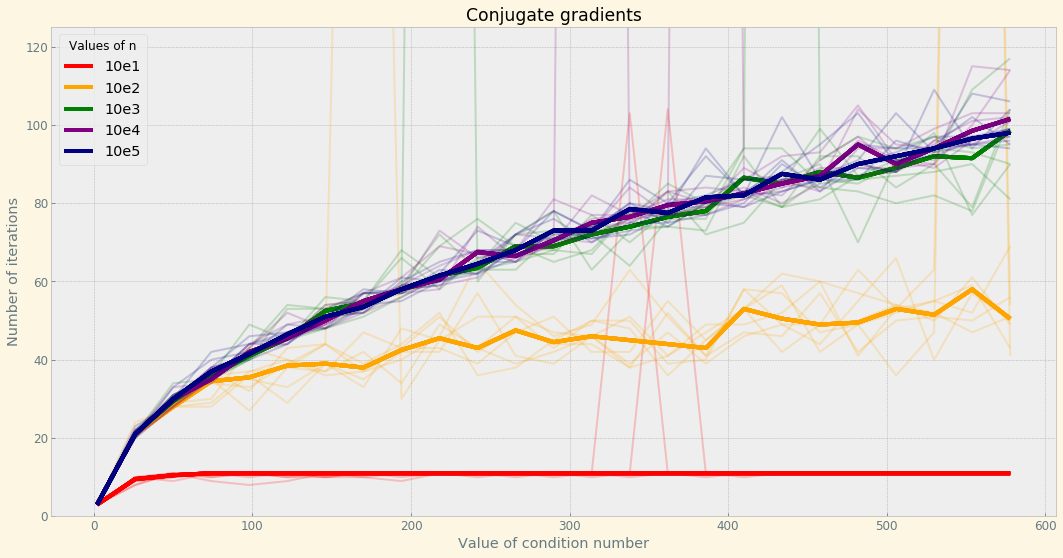
*Graph 1.1 Conjugate gradients with standard stop criterion*

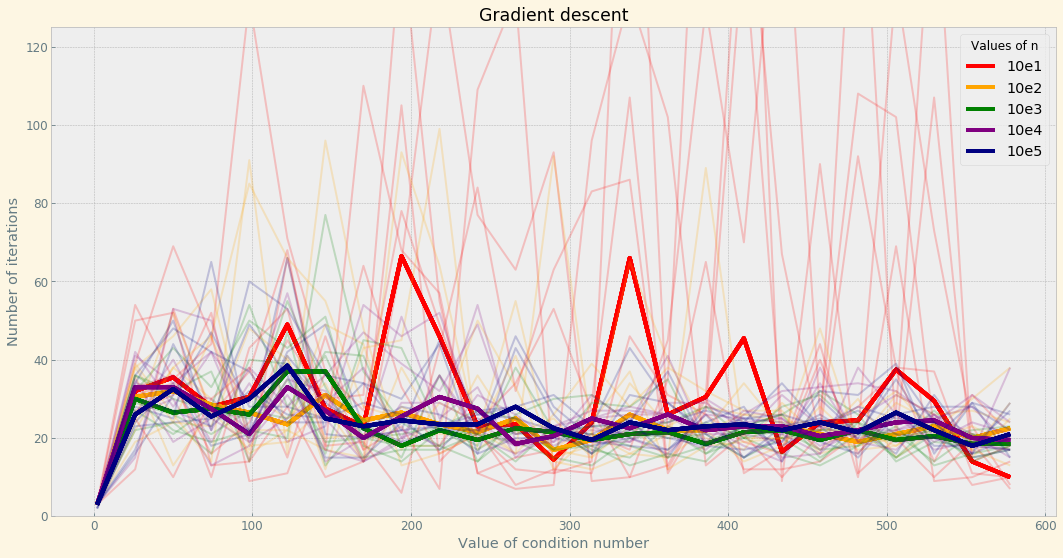
*Graph 1.2 Gradient descent with point far from zero*

----


Выводы

*Ключевой вопрос: Сравните результат метода сопряженных градиентов с результатом
градиентного спуска. Какие выводы можно сделать?*

1. **Семейства**. В методе CG (*Graph 1.1*) мы видим четкую разницу между группой малых семейств и больших. Характер роста можно назвать логарифмическим для больших семейств. Можно утверждать, что на изучаемом диапазоне зоне линии для первых двух семейств стоят не только отдельно друг от друга, но и от группы больших семейств. Напротив, начиная с $n = 1000$ можно заметить, что графики почти идентичны как в среднем, так и в каждом отдельном эксперименте. Также можно предположить, что выходящие на плато графики малых семейств указывают на возможный аналгичный итог для больших семейств на бесконечности. Аргументов в пользу этого является то, что чем меньше семейство, тем быстрей оно выходит на платой (при n=10 это происходит сразу). Напротив, в GD (*Graph 1.2*), который, в отличии от предыдущего эксперимента, запускался на большем диапазне значений обусловленности, семейства в определенный момент сходятся. Благодаря графикам первого эксперимента мы видим, что характер роста изначально был схож с тем, что мы видим сейчас в CG, однако с определенного момента графики сходятся в один. Значение семейства влияет лишь на близость к асимптоте и амплитуду. 


2. **Колебания**. На графике CG мы видим, что разброс для малых семейств намного менее значителен, чем для GD. Более того, амплитуда меньше не только для отдельных экспериментов, но и для средних линий. Тенденция сохраняется и на большие семейства, правда становится чуть менее заметна. Особенно интересно, что наименее колебательный характер имеет график как раз наименьшего семейства, что полностью противоположно результатам GD. В то же время, у CG мы сталкиваемся с редкими аномальными выбросами, которые значительно опережают максимальные значения GD.


3. **Число обсуловленности**. В отличии от выводов прошлой работы, при расширении области определения мы видим, что GD на всех семействах при росте $k$ выходит на определенное плато в районе 20 итераций. Напротив, CG сохраняет на изучаемом промежутке внешней вид графика логарифмической сложности и, как уже указывалось ранее, не приходит к полной идентичности всех семейств. Если наложить графики друг на друга, можно увидеть, что практически все семейства (кроме 10) выполняются за большее число итераций на CG.


4. **Точка начала**. Согласно сопоставлению основных графиков, где приводятся данные для x не близкого к нулю, и графиков из дополнительных материалов (*Graph 1.A & 1.B*) можно сделать следующие выводы: CG не зависит от точки, из которой начинается алгоритм, в отличии GD. Если первый алгоритм демонстрирует крайне схожие результаты с теми, по которым приводился весь предыдущий анализ, то второй меняется сразу по нескольким направлениям. Во-первых, колоссальный рост числа итераций для всех семейств, превыщающий все значения CG. Во-вторых, серьезное увеличения колебательного параметра для всех семейств с ростом значения обусловленности. Чем меньше семейству, тем более ощутим данный показатель. Не приходится говорить о как-то плато, сходимости всех линий к одной асимптоте и т.д.


5. **Критерий остановки**. Так как была определенная дискуссия вокруг критерия остановки для CG, было принято решение привести оба случая. На основном графике мы говорим о стандартном неравенстве $\epsilon \cdot \|b\|_2 \geq \|Ax_k-b\|_2$. На графике из дополнительных материалов (*Graph 1.C*) используется модификация $\sqrt{\epsilon} \cdot \|Ax_0-b\|_2 \geq \|Ax_k-b\|_2$. Именно второй метод предполагается в итоге для сравнения. Также видим определенные отличия. Во-первых, меняется характер роста: все семейства выходят на идентичное плато (за исключением n=10). Наименьшее семейство демонстрирует теперь рост в начале, ни о какой линий и независимости от k говорить не приходится. Значения итераций не превосходят теперь GD (*Graph 1.2*), а даже заметно меньше. Несмотря на увеличившуюся амплитуду при малых k, она все еще несоизмерима с GD при любой начальной точке. Более того, в правой части графика амплитуда становится больше у классическго критерия остановки в случае больших семейств. Стоит отметить, что пропали аномальные выбросы по числу итераций.

----

Дополнительные материалы 

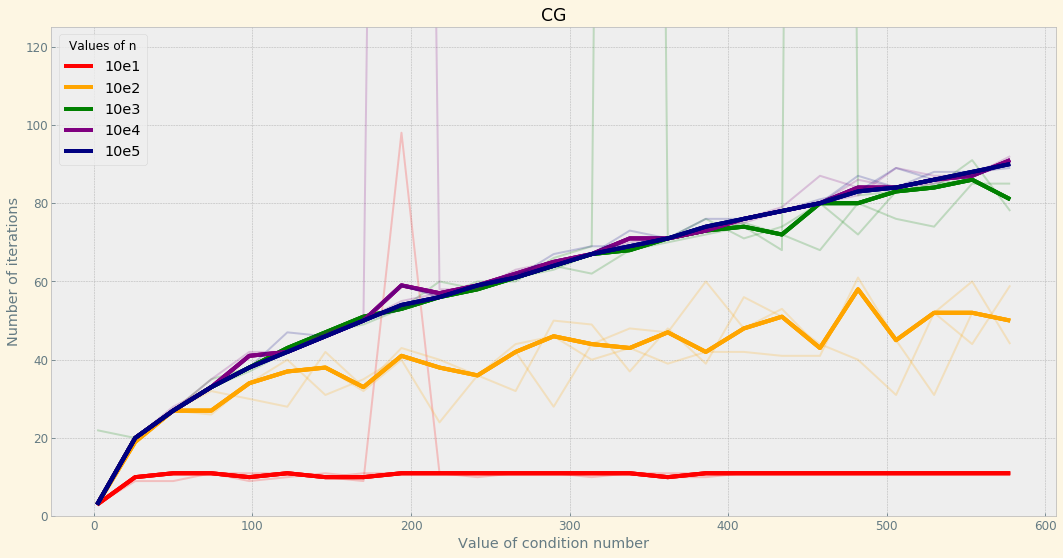
*Graph 1.A Conjugate gradients with point near to zero*

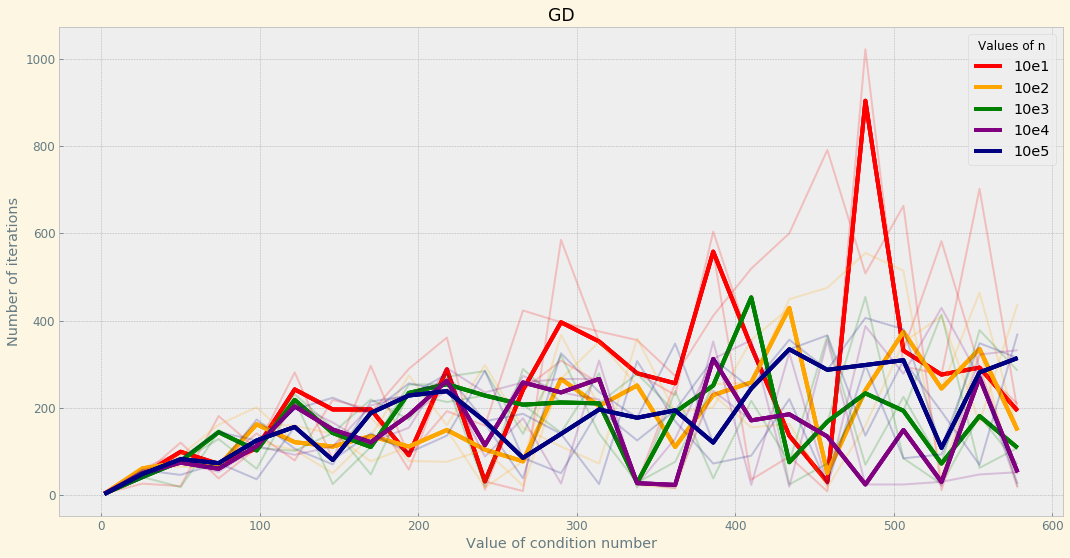
*Graph 1.B Gradient descent with point near to zero*

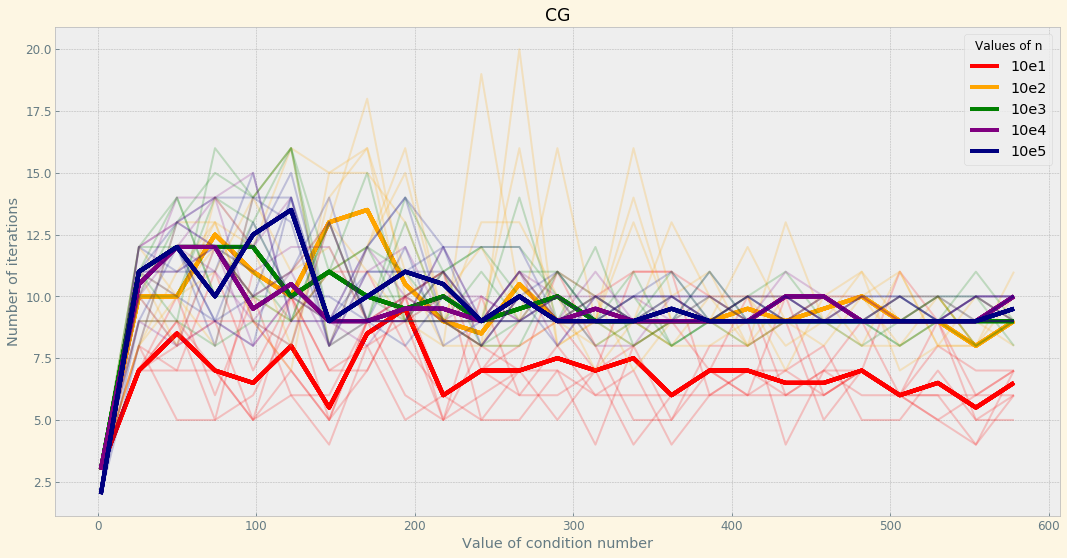
*Graph 1.C Conjugate gradients with modified stop criterion*

----

### Эксперимент 2. Выбор размера истории в методе L-BFGS

---

Дизайн эксперимента

> Эксперимент во многом напоминает третий из предыдущей практики. Здесь мы на задаче логистиечской регрессии итерируемся по сетке значений гиперпараметра `memore_size`, используемого в реализации метода lbfgs. Сам метод представляет из себя квазиньютоновский метод "на каждом шаге аппроксимирующий настоящий гессиан $\nabla^2 f(x_k)$ с помощью некоторой матрицы $B_k$ и выбирают направление как решение определенной системы." 

> Исследуемый же гиперпараметр влияет на кол-во прошедших итераций, который необходимо сохранять в историю и использовать для пересчета направления. Вспомогательная функция, основывающаяся в своих вычислениях на данной истории, принимает как отправное значение $-\nabla f(x_k)$. Смысл всех вводимых модификаций заключается в итоговом исключении операций вычисления и сохранения гессиана как таковых в алгоритме. 

> Тогда как дефолтное значение истории равняется 10, в рамках эксперимента будут происходить итерации в диапазоне от 0 до 50 с меняющимся шагом: $\ell \in [1, 3, 5, 7, 10, 15, 20, 35, 50]$. Все вычисления основываются на логистическом оракуле, созданном при помощи датасета news20.binary.

> Сложность итерации в зависимости от $\ell$ и $n$ (вычисления основываются на работе [master thesis](https://cs.nyu.edu/~overton/mstheses/skajaa/msthesis.pdf)):
>
> **Update**: $4ln$ multiplications $\rightarrow$ 
>
> **Computation complexity** = $\mathcal{O}(ln)$ per iteration. If $l << n \rightarrow  \mathcal{O}(n)$
>
>Preserve l last iterations: **space complexity** equals $\mathcal{O}(ln)$

-----

Результаты эксперимента

#### 2.1  Загрузка датасета

In [25]:
X, y = load_svmlight_file('news20.binary')

#### 2.2  Создание основных графиков

In [ ]:
plt.rcParams["figure.figsize"] = (18,8)
fig, ax = plt.subplots(1, 2)
point = np.zeros(X.shape[1])
comp_oracle = create_log_reg_oracle(X, y, regcoef = 1 / X.shape[0])
colors = ['blue', 'red', 'slateblue', 'darkseagreen', 'pink', 'navy', 'aqua', 'palegreen', 'crimson']
for i, l in enumerate(tqdm([1, 3, 5, 7, 10, 15, 20, 35, 50])):
    [x_star_n, msg_n, history_n] = lbfgs(comp_oracle, point, memory_size=l, trace=True)
    zero = np.power(history_n['grad_norm'][0], 2)
    ax[0].plot(np.arange(0, len(history_n['time'])), np.log(np.power(history_n['grad_norm'], 2) / zero),
               label="Memory size: {}".format(l), color=colors[i])
    ax[1].plot(history_n['time'],  np.log(np.power(history_n['grad_norm'], 2) / zero), label="Memory size: {}".format(l), color=colors[i])
ax[0].set(title='Gradient norm square value to iteration graph',
              ylabel='Log Grad norm square', xlabel='Iterations')
ax[0].legend(fontsize='large', loc='upper right')
ax[1].set(title='Gradient norm square value to real time graph',
          ylabel='Log Grad norm square', xlabel='Real time')
ax[1].legend(fontsize='large', loc='upper right')
plt.show()

#### 2.3 Графики

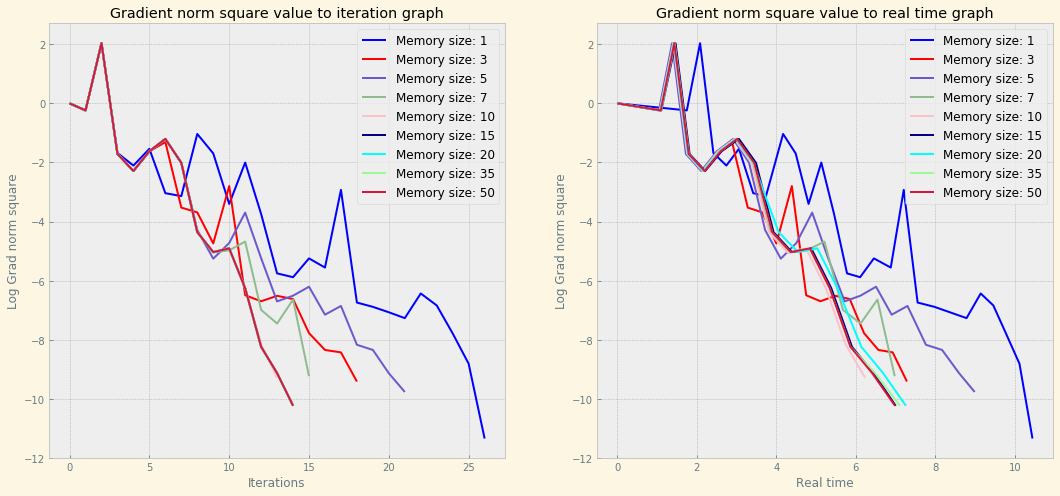
*Graph 2. Gradient norm square to a) iterations b) time in seconds*

----

Выводы

*Ключевой вопрос: Исследуйте, как влияет размер истории в методе L-BFGS на поведение метода.*

1. Итак, мы видим картину совпадения теории и практики: линии, отвечающие за значение `memory_size` большее 10-15 (назовем порогом), полностью совпадают (*Graph 2*). Аналогичные результаты будут получены, если повысить верхнюю границу перебираемых значений до 100. Это является следствием того факта, что число итераций не может превышать полученное при минимальном, нулевом гиперпараметре (без истории). 


2. Имеются незначительные расхождения по времени для всех графиков (*Graph 2b*), в отличии от идентичных линий для числа итераций (*Graph 2a*) после порога. При этом не приходится говорить о положительной корреляции значения $\ell$ и времени после прохождения порога. Все несовпадения лежат в рамках случайности.


3. До порога мы можем увидеть, что значения гиперпараметра положительно влияет на скорость сходимости метода. В то же время, значения нормы градиента для $\ell = 3$ и $\ell = 7$ против времени указывают на малую эффективность.


4. Таким образом, $\ell$, равняющееся порогу (10-15) по всей видимости оптимальное наименьшее значение.

----

### Эксперимент 3. Сравнение методов на реальной задаче логистической регрессии
---

Дизайн эксперимента

> В рамках эксперимента соотносятся результаты методов, реализованных для данной работы, а именно: `lbfgs` и `hessian_free_newton`, опирающейся в работе на CG. Сравнение идет с тестируемым ранее алгоритмом GD, уже упоминавшимся в данной работе. Вычисления происходят на основе пяти датасетов, так же уже не раз использованных.

> Цитата из четвертого эксперимента первой работы: "Сравнение будет проходить по трем дисциплинам, отображенных в графиках: а) Зависимость значения функции против номера итерации метода б)Зависимость значения функции против реального времени работы и в) Зависимость логарифма относительного квадрата нормы градиента против реального времени работы."

-----

Результаты эксперимента

#### 3.1  Массив датасетов

In [3]:
paths = ['w8a.train', 'gisette_scale',
         'real-sim', 'rcv1_train.binary', 'news20.binary']

#### 3.2  Создание основных графиков

In [ ]:
plt.style.use('bmh')
pbar = tqdm((paths))
for dataset in pbar:
    pbar.set_description("Processing dataset {0}".format(dataset))
    plt.rcParams["figure.figsize"] = (24,10)
    plt.rcParams["font.size"] = 12
    fig, ax = plt.subplots(1, 3)
    X, y = load_svmlight_file(dataset)
    point = np.zeros(X.shape[1])
    comp_oracle = create_log_reg_oracle(X, y, regcoef = 1 / y.shape[0])
    for method in [newton, gradient_descent, hessian_free_newton]:
        [x_star_n, msg_n, history_n] = method(comp_oracle, point, trace=True)
        ax[0].plot(np.arange(0, len(history_n['func'])), history_n['func'], label="{}".format(method.__name__))
        ax[1].plot(history_n['time'], history_n['func'], label="{}".format(method.__name__))
        zero = np.power(history_n['grad_norm'][0], 2)
        ax[2].plot(history_n['time'], np.log(np.power(history_n['grad_norm'], 2) / zero), 
                   label="{}".format(method.__name__))
    ax[0].set(title='Function value to iterations graph',
              ylabel='Function value', xlabel='Iterations')
    ax[1].set(title='Function value to real time graph',
              ylabel='Function value', xlabel='Real time')
    ax[2].set(title='Gradient norm square value to real time graph',
              ylabel='Gradient norm square', xlabel='Real time')
    plt.suptitle('Dataset: {0}'.format(dataset), weight='bold', size=22)
    ax[0].legend(fontsize='large', loc='upper right')
    ax[1].legend(fontsize='large', loc='upper right')
    ax[2].legend(fontsize='large', loc='upper right')
    plt.show()

#### 3.3 Графики

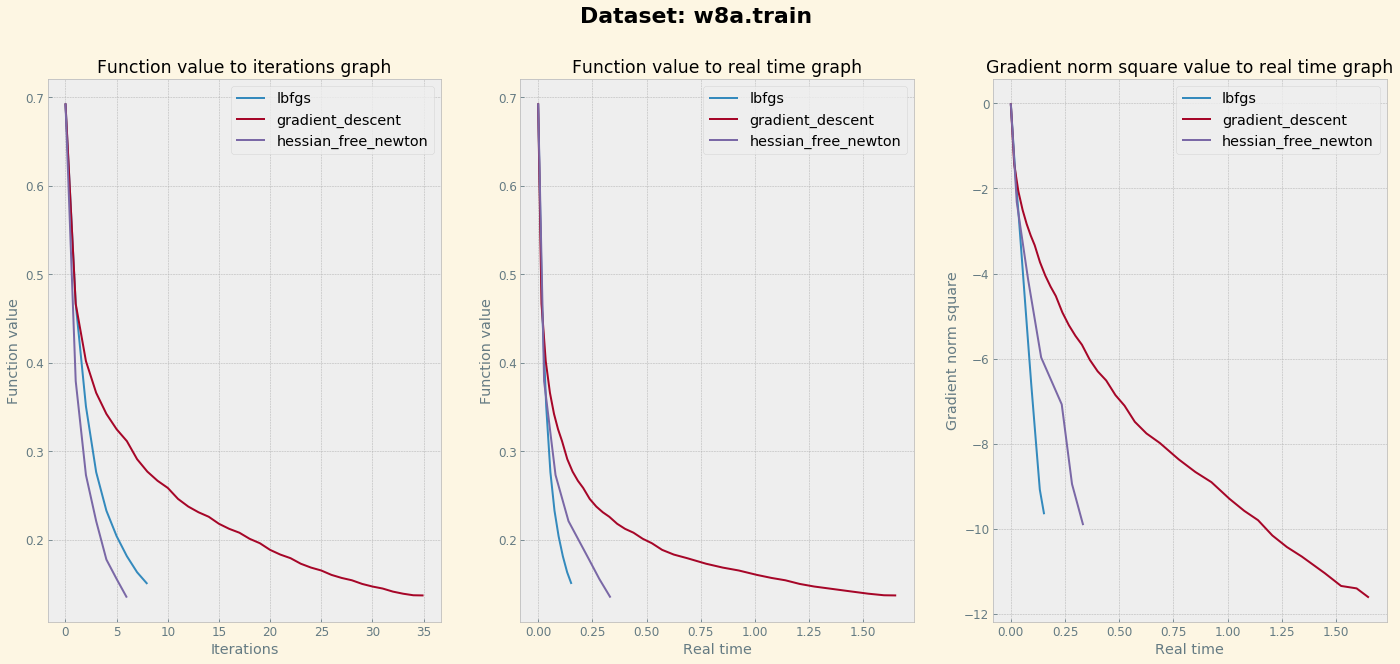
*Graph 3.1. Results for `w8a` datatset*

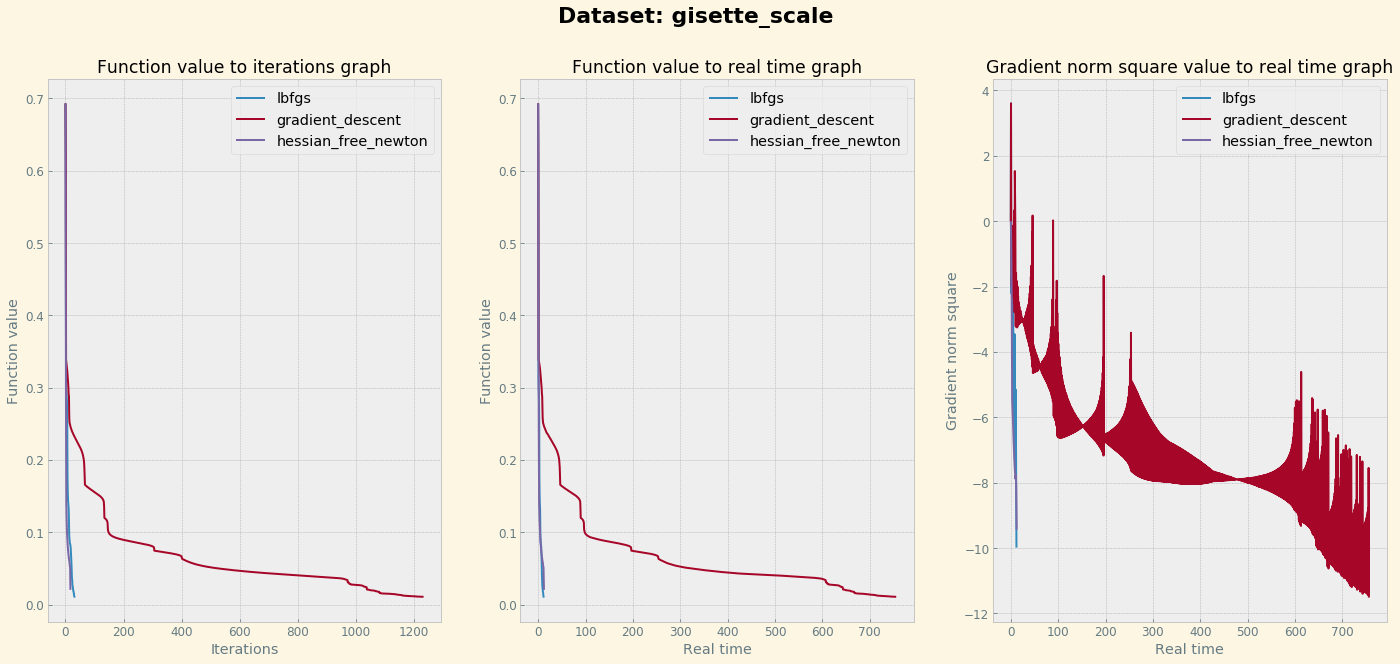
*Graph 3.2. Results for `gisette` datatset*


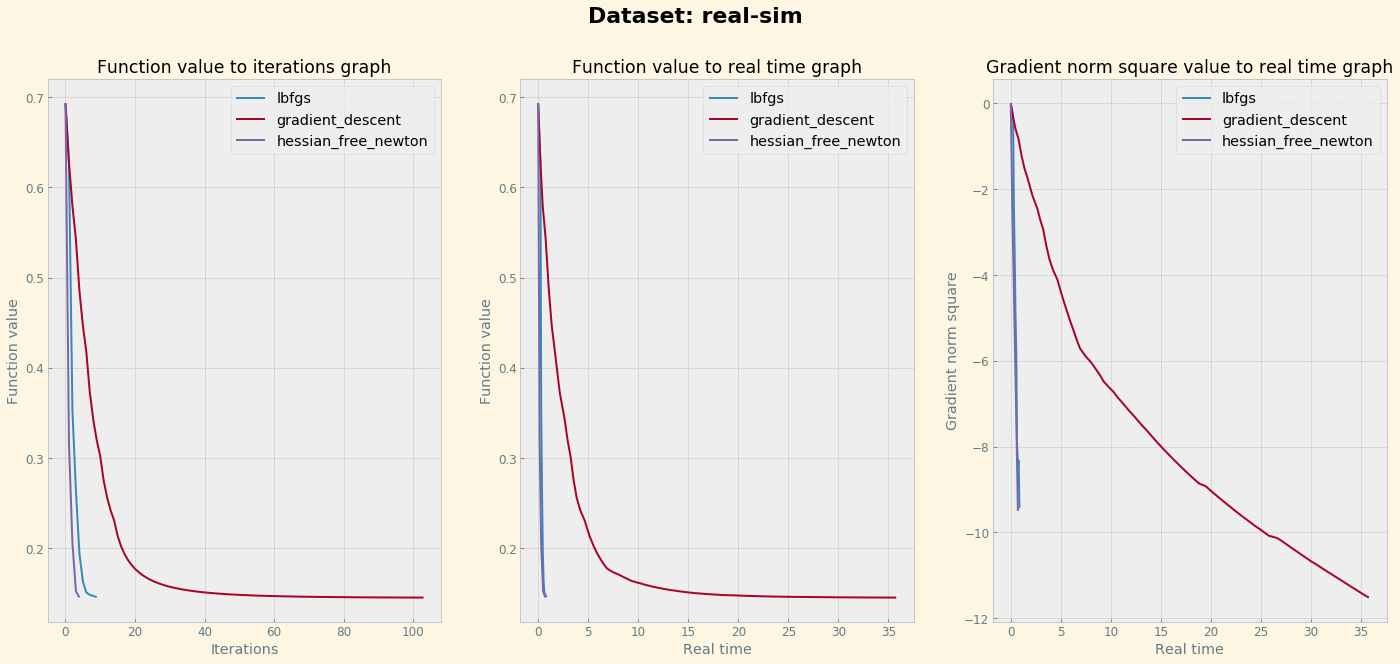
*Graph 3.3. Results for `real-sim` datatset*


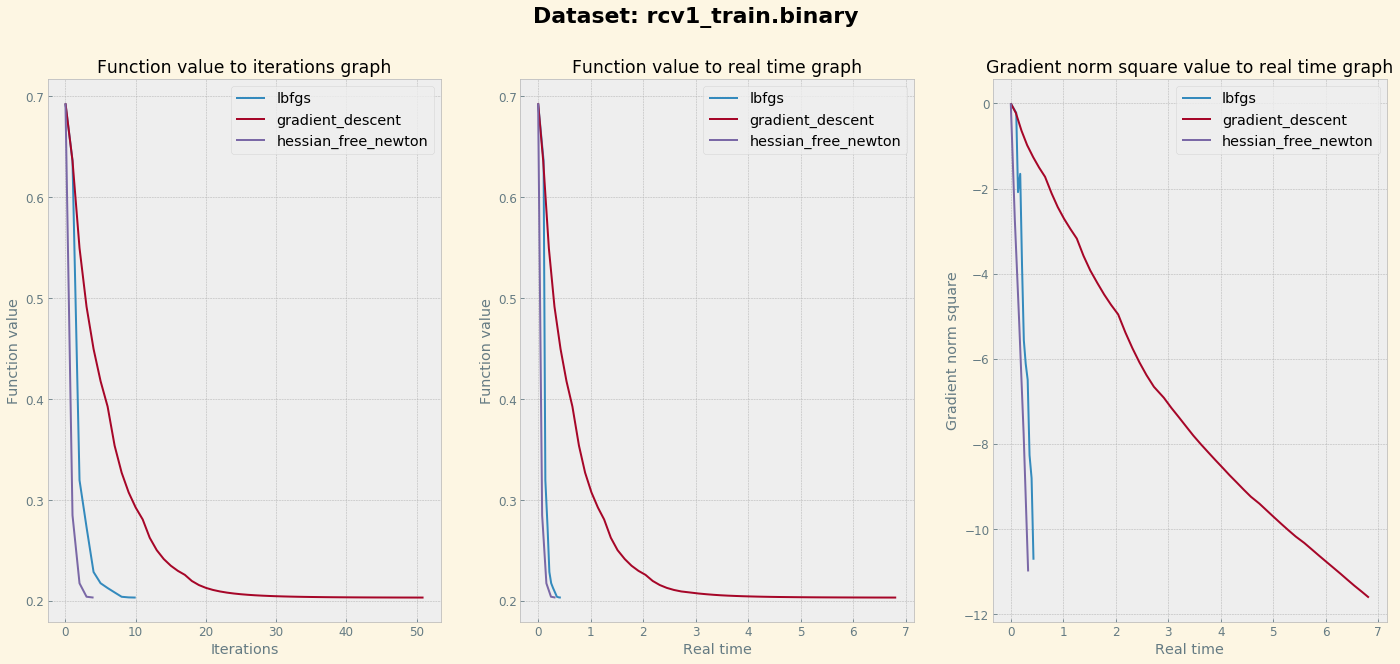
*Graph 3.4. Results for `rcv1` datatset*



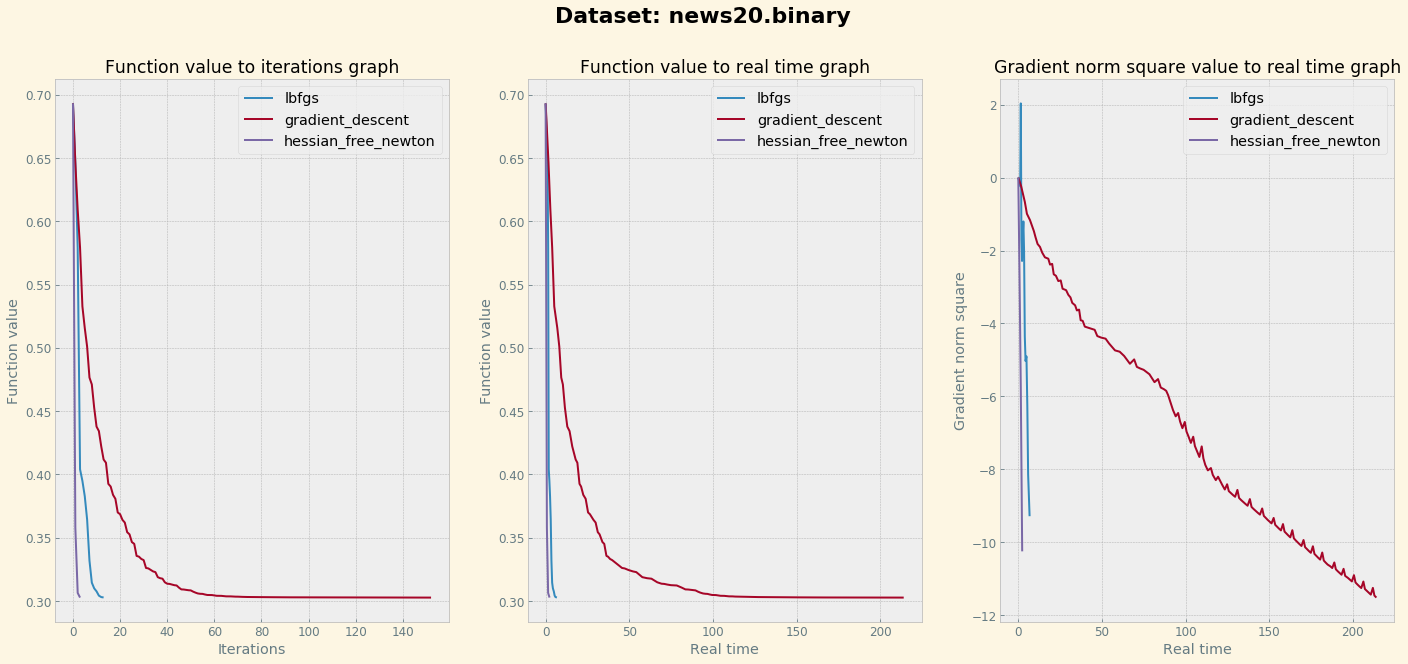
*Graph 3.2. Results for `news20` datatset*

----

Выводы

*Ключевой вопрос: Какие выводы можно сделать по результатам этого эксперимента? Какой из методов лучше и в
каких ситуациях?*

1. Заметим, что далеко не сразу были получены представленные результаты. Основной проблемой являлись вычислительные сложности алгоритма HFN, дополнительно усложнявшиеся не оптимальной реализацией. Тем не менее, удалось достичь желанных показателей.


2. Именно благодаря многократному редактированию кода удалось добиться того, чтобы графики функций на итерацию совпадали с функцией на время. Если изначально усеченный метод Ньютона не превосходил по числу итераций ни один другой алгоритм ни на одном датасете, при этом занимая наибольшее время, то теперь картина более рациональная: HFN оказывается лучше и по числу итераций, и по требуемому времени на всех датасетах, кроме w8a. Исключение можно отнести к случайности, так как массив крайне невелик и разница во времени может являтся просто погрешностью вычислений. Тем не менее, нельзя не признать, что разница с lbfgs мизерная в контексте первых двух групп графиков, работающих с значениями функции (на *Graph 3.2* даже сложно отличить линии). 


3. Отличие между двумя лидерами встречается в рамках третьей группы графиков. Ясно видно, что HFN чаще лучше приближает норму оптимального градиента.


4. Явным андредогом выступает градиентный спуск, который буквально во всех датасетах проигрывает и по числу итераций, и по времени, и по минимизации относительной нормы градиента. На определенных датасетах мы видим даже не гиперболу, а практически прямую (*Graph 3.3 & 3.1*). Однако действительную неэффективность GD можно понять, исходя из результатов для самого тяжелого в вычислениях массива - gisette (*Graph 3.2*). По многочисленным колебаниям относительной нормы градиента и общему числу итераций, превышаещему 1200, можно осознать контраст данного метода с остальными. Схожая ситуация с колебаниями, правда менее выраженная, на массиве news20. Также можно отметить, что в большинстве случаев относительный квадрат нормы достигает наименьших значений как раз при использовании GD.


--------
------
-----